In [ ]:
!pip install transformers datasets tweet-preprocessor
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import preprocessor as p # tweet-preprocessor
import nltk
import re
import seaborn as sns
import torch

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from datasets import Dataset
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm

In [3]:
def auc_score(preds, labels):
  soft_preds = softmax(preds, axis=1) # logit -> probability
  print(preds.shape, labels.shape)
  if np.shape(preds)[1] > 2: # check for multi-class
    return roc_auc_score(labels, soft_preds, multi_class='ovr')
  else:
    soft_preds = soft_preds[:,1]
    return roc_auc_score(labels, soft_preds)

In [8]:
!ls drive/Shareddrives/

MyDrive  Shareddrives


In [9]:
X_val = pd.read_csv("/content/drive/MyDrive/EE 460J/X_val.csv.zip")
y_val = pd.read_csv("/content/drive/MyDrive/EE 460J/y_val.csv.zip")

In [ ]:
X_val.head()

In [14]:
def preprocess_tweet(tweet):
  clean_tweet = tweet.replace('@', '')
  clean_tweet = clean_tweet.replace('#', '')
  clean_tweet = clean_tweet.replace('&', '')
  clean_tweet = re.sub(r'[^A-Za-z0-9.!, ]+', '', clean_tweet)
  split = [word.lower() for word in clean_tweet.split() if 'http' not in word.lower() and 'jpg' not in word.lower() and 'www' not in word.lower() and word.lower() not in['amp', 'qt']]
  return ' '.join(split)


data = [X_val, y_val['party']]
dataset = pd.concat(data, axis=1)
dataset = dataset[dataset["party"].isin(["R","D"])]
dataset["label"] = dataset['party'].apply(lambda party: 1 if party=='R' else 0)



In [15]:
dataset_test = dataset.sample(frac=0.4, random_state=42)
dataset_test

,Unnamed: 0,Unnamed: 0.1,id,screen_name,user_id,time,link,text,source,clean_text,party,label
7549,178819,1846,1247320081941569536,RepDonBeyer,2962868158,2020-04-06T20:27:36-04:00,https://www.twitter.com/JECDems/statuses/12473...,RT @JECDems .@RepDonBeyer urges Mnuchin to qui...,Twitter for iPhone,rt jecdems .repdonbeyer urges mnuchin to quick...,D,0
11119,161401,1218,1244415050108014592,RepKathleenRice,2970462034,2020-03-29T20:04:02-04:00,https://www.twitter.com/RepKathleenRice/status...,It’s National Vietnam War Veterans Day. \n\nTo...,Twitter for iPhone,its national vietnam war veterans day. today w...,D,0
34664,310857,889,1271923075265724416,senrobportman,18915145,2020-06-13T17:51:06-04:00,https://www.twitter.com/senrobportman/statuses...,Heartbreaking news coming out of the Cincinnat...,Twitter for iPhone,heartbreaking news coming out of the cincinnat...,R,1
100271,377166,456,1285583410845691904,RepJohnYarmuth,384913290,2020-07-21T10:32:24-04:00,https://www.twitter.com/RepJohnYarmuth/statuse...,If Donald Trump is the Grand Canyon of moralit...,Twitter for iPhone,if donald trump is the grand canyon of moralit...,D,0
52478,75415,3332,1227975742761455616,RepMaloney,258900199,2020-02-13T10:20:06-05:00,https://www.twitter.com/VAratifyERA/statuses/1...,RT @VAratifyERA The ERA is still as relevant a...,Twitter Web App,rt varatifyera the era is still as relevant an...,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...
66304,516537,894,1314198822797615104,RepDonBeyer,2962868158,2020-10-08T09:39:50-04:00,https://www.twitter.com/RepDonBeyer/statuses/1...,As the President pitches a tantrum over basic ...,TweetDeck,as the president pitches a tantrum over basic ...,D,0
72327,150867,4128,1242451346466451456,SenatorTimScott,217543151,2020-03-24T10:00:59-04:00,https://www.twitter.com/SenJohnBarrasso/status...,RT @SenJohnBarrasso You are either helping rig...,TweetDeck,rt senjohnbarrasso you are either helping righ...,R,1
101080,232348,927,1256245018962137088,RepCasten,1083472286089396224,2020-05-01T11:32:07-04:00,https://www.twitter.com/RepCasten/statuses/125...,May is #MentalHealthMonth. There are simple th...,Twitter Web App,may is mentalhealthmonth. there are simple thi...,D,0
36654,60058,216,1225501504561438720,NormaJTorres,236279233,2020-02-06T14:28:22-05:00,https://www.twitter.com/NormaJTorres/statuses/...,On International Day of Zero Tolerance for fem...,Twitter Web App,on international day of zero tolerance for fem...,D,0


In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                        do_lower_case=True)

encoded_data_test = tokenizer.batch_encode_plus(
  dataset_test.clean_text.values, 
  add_special_tokens=True, 
  return_attention_mask=True, 
  padding=True, 
  truncation=True, 
  return_tensors='pt'
)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(dataset_test.label.values)

BATCH_SIZE=128

test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

test_dataloader = DataLoader(test_data,
                             sampler=SequentialSampler(test_data),
                             batch_size=BATCH_SIZE)

In [17]:
def evaluate(model, dataloader):
  model.to(device)
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []
  
  progress_bar = tqdm(dataloader)
  for batch in progress_bar:  
    # convert data to CUDA
    batch = tuple(b.to(device) for b in batch)
    
    inputs = {
        'input_ids':      batch[0],
        'attention_mask': batch[1],
        'labels':         batch[2],
    }

    with torch.no_grad():        
        outputs = model(**inputs) # get predictions
        
    loss = outputs[0]
    logits = outputs[1]
    loss_val_total += loss.item()

    logits = logits.detach().cpu().numpy()
    label_ids = inputs['labels'].cpu().numpy()
    predictions.append(logits)
    true_vals.append(label_ids)

  loss_val_avg = loss_val_total/len(dataloader) 

  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)

  auc = auc_score(predictions, true_vals)

  print(f'AUC: {auc}')
  print(f'Cross-entropy loss: {loss_val_avg}')
  print(f"Accuracy: {accuracy_score(true_vals, np.argmax(predictions, axis=1))}")  
  sns.heatmap(confusion_matrix(true_vals, np.argmax(predictions, axis=1)), annot=True, fmt="d")

In [21]:
!ls drive/MyDrive/EE\ 460J

 10k_tweets_model.model			 election_tweet_ids_pls_hydrate.txt
 2010.00600.pdf				 finetuned_BERT_epoch_1.model
 2020_labled_political_tweets.csv.zip	'Lab 5.gdoc'
 290_tweets_with_labels.csv		 tweets_3k.csv
'460J Final Project Links.docx'		'Twitter API Keys.gdoc'
'50k_tweets_model (1).model'		'USElection Data Set Explanation_2.pdf'
 50k_tweets_model.model			 uselection_tweets_1jul_11nov.zip
 5k_tweets_model.model			 X_train.csv.zip
 Brainstorm.gdoc			 X_val.csv.zip
'Copy of finetuned_BERT_epoch_2.model'	 y_train.csv.zip
'Data Collection.ipynb'			 y_val.csv.zip


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


(47324, 2) (47324,)
AUC: 0.9555589070555484
Cross-entropy loss: 0.3090455831305401
Accuracy: 0.8831037105908207


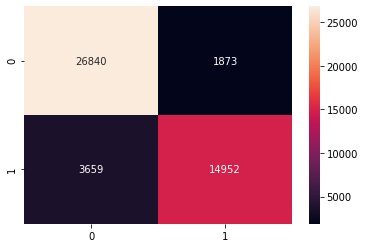

In [22]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=2,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.load_state_dict(torch.load("/content/drive/MyDrive/EE 460J/finetuned_BERT_epoch_1.model"))

evaluate(model, test_dataloader)